In [1]:
# Logical Settings
import os
# os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,4'      # 3 is just GPU for display.

In [2]:
import jax
jax.devices()

[gpu(id=0), gpu(id=1), gpu(id=2), gpu(id=3)]

In [3]:
import numpy as np

import jax
from jax import lax, random, numpy as jnp

import flax
from flax import struct, traverse_util, linen as nn
from flax.core import freeze, unfreeze
from flax.training import train_state, checkpoints

import optax

from functools import partial
from typing import Optional, Callable, Any

2024-03-22 13:50:45.615485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Hyperparams Settings
num_epochs = 100
batch_size = 32

In [5]:
# Data loading
import tensorflow as tf
import tensorflow_datasets as tfds

train_ds = tfds.load('mnist', split='train')
test_ds = tfds.load('mnist', split='test')

def data_normalize(ds):
    return ds.map(lambda sample: {
        'image': tf.cast(sample['image'], tf.float32) / 256.,
        'label': sample['label']
    })

train_ds = data_normalize(train_ds)
test_ds = data_normalize(test_ds)

# train_ds = train_ds.repeat(num_epochs).shuffle(1024).batch(batch_size).prefetch(1)
train_ds = train_ds.shuffle(1024).batch(batch_size).prefetch(1)
test_ds = test_ds.shuffle(1024).batch(batch_size).prefetch(1)

2024-03-22 13:50:51.868097: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
# Sharding
from jax.sharding import Mesh, PartitionSpec, NamedSharding
from jax.experimental import mesh_utils

P = PartitionSpec
mesh = Mesh(mesh_utils.create_device_mesh((4,)), axis_names=('data',))

def with_mesh(f):
    def wrapper(*args, **kwargs):
        with mesh:
            return f(*args, **kwargs)
    return wrapper


In [7]:
# Model Construction; Correct!
class ResNetBlock(nn.Module):
    layer_thick: int
    subsample: bool = False

    # kernel_init = nn.initializers.variance_scaling(2.0, mode='fan_out', distribution='normal')
    # kernel_init = nn.with_partitioning(kernel_init, (None, 'data'))

    @nn.compact
    def __call__(self, x, train: bool=True):

        # forward
        z = nn.Conv(self.layer_thick,
                    kernel_size=(3, 3),
                    strides=(1, 1) if not self.subsample else (2, 2),
                    # kernel_init=nn.with_partitioning(nn.initializers.variance_scaling(2.0, mode='fan_out', distribution='normal'), (None, 'data')),
                    # bias_init=nn.with_partitioning(nn.initializers.zeros, ('data',)),
                    )(x)
        # print(z.shape)
        z = nn.BatchNorm(use_running_average=not train)(z)
        z = nn.relu(z)
        z = nn.Conv(self.layer_thick,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    # kernel_init=nn.with_partitioning(nn.initializers.variance_scaling(2.0, mode='fan_out', distribution='normal'), (None, 'data')),
                    # bias_init=nn.with_partitioning(nn.initializers.zeros, ('data',)),
                    )(z)
        # print(z.shape)

        z = nn.BatchNorm(use_running_average=not train)(z)
        z = nn.relu(z)

        if self.subsample:
            x = nn.Conv(self.layer_thick,
                    kernel_size=(1, 1),
                    strides=(2, 2),
                    # kernel_init=nn.with_partitioning(nn.initializers.variance_scaling(2.0, mode='fan_out', distribution='normal'), (None, 'data')),
                    # bias_init=nn.with_partitioning(nn.initializers.zeros, ('data',)),
                    )(x)

        z = nn.relu(z + x)
        return z


class ResNet(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool):
        # Initial layer
        x = nn.Conv(64,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    kernel_init=nn.with_partitioning(nn.initializers.variance_scaling(2.0, mode='fan_out', distribution='normal'), (None, None, None, 'data')),
                    bias_init=nn.with_partitioning(nn.initializers.zeros, ('data',)),
                    name='conv_init'
                    )(x)
        x = nn.BatchNorm(name='bn_init')(x, use_running_average=not train)
        # print(x.shape)

        x = nn.relu(x)
        x = nn.max_pool(x,
                        window_shape=(3, 3),
                        strides=(1, 1),
                        padding='SAME')
        # print(x.shape)

        # Skip layers
        for i in range(4*5):
            # print(i, (i > 0) & (i%4 == 0), '//', 64 * 2**(i//4))
            x = ResNetBlock(64 * 2**(i//4),
                            subsample=(i > 0) & (i%4 == 0),
                            )(x, train=train)
        # last layer
        # print(x.shape)

        # x = nn.avg_pool(x,
                        # window_shape=(2, 2),
                        # strides=(1, 1))
        x = x.mean(axis=(1, 2))
        # print(x.shape)

        x = x.reshape((x.shape[0], -1))
        # print(x.shape)
        x = nn.Dense(10)(x)
        # print(x.shape)

        return x


from pprint import pprint

module = ResNet()
x = jnp.ones((1, 28, 28, 1))
variables = module.init(jax.random.PRNGKey(42), x, train=False)
pprint(jax.tree_map(jnp.shape, variables))


{'batch_stats': {'ResNetBlock_0': {'BatchNorm_0': {'mean': (64,), 'var': (64,)},
                                   'BatchNorm_1': {'mean': (64,),
                                                   'var': (64,)}},
                 'ResNetBlock_1': {'BatchNorm_0': {'mean': (64,), 'var': (64,)},
                                   'BatchNorm_1': {'mean': (64,),
                                                   'var': (64,)}},
                 'ResNetBlock_10': {'BatchNorm_0': {'mean': (256,),
                                                    'var': (256,)},
                                    'BatchNorm_1': {'mean': (256,),
                                                    'var': (256,)}},
                 'ResNetBlock_11': {'BatchNorm_0': {'mean': (256,),
                                                    'var': (256,)},
                                    'BatchNorm_1': {'mean': (256,),
                                                    'var': (256,)}},
                 'ResNetBl

In [8]:
# Ready for train
from flax.training.train_state import TrainState
from jax.lax import with_sharding_constraint

params = variables['params']
batch_stats = variables['batch_stats']
y, updates = module.apply(
    {'params': params, 'batch_stats': batch_stats},
    x, train=True, mutable=['batch_stats']
)
batch_stats = updates['batch_stats']

class TrainState(TrainState):
    batch_stats: Any

@with_mesh
@partial(jax.jit, static_argnums=(0,))
def create_state(module):
    variables = module.init(jax.random.PRNGKey(1), jnp.ones((1, 28, 28, 1)), train=True)
    state = TrainState.create(
        apply_fn=module.apply,
        params=params,
        batch_stats=batch_stats,
        tx=optax.adam(1e-3)
    )
    state = jax.tree_map(jnp.asarray, state)
    state_spec = nn.get_partition_spec(state)
    state = with_sharding_constraint(state, state_spec)
    return state

state = create_state(module)
pprint(jax.tree_map(jnp.shape, state))

TrainState(step=(), apply_fn=<bound method Module.apply of ResNet()>, params={'Dense_0': {'bias': (10,), 'kernel': (1024, 10)}, 'ResNetBlock_0': {'BatchNorm_0': {'bias': (64,), 'scale': (64,)}, 'BatchNorm_1': {'bias': (64,), 'scale': (64,)}, 'Conv_0': {'bias': (64,), 'kernel': (3, 3, 64, 64)}, 'Conv_1': {'bias': (64,), 'kernel': (3, 3, 64, 64)}}, 'ResNetBlock_1': {'BatchNorm_0': {'bias': (64,), 'scale': (64,)}, 'BatchNorm_1': {'bias': (64,), 'scale': (64,)}, 'Conv_0': {'bias': (64,), 'kernel': (3, 3, 64, 64)}, 'Conv_1': {'bias': (64,), 'kernel': (3, 3, 64, 64)}}, 'ResNetBlock_10': {'BatchNorm_0': {'bias': (256,), 'scale': (256,)}, 'BatchNorm_1': {'bias': (256,), 'scale': (256,)}, 'Conv_0': {'bias': (256,), 'kernel': (3, 3, 256, 256)}, 'Conv_1': {'bias': (256,), 'kernel': (3, 3, 256, 256)}}, 'ResNetBlock_11': {'BatchNorm_0': {'bias': (256,), 'scale': (256,)}, 'BatchNorm_1': {'bias': (256,), 'scale': (256,)}, 'Conv_0': {'bias': (256,), 'kernel': (3, 3, 256, 256)}, 'Conv_1': {'bias': (256

In [9]:
# Train step
@with_mesh
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits, updates = state.apply_fn(
            {'params': params, 'batch_stats': batch_stats},
            x=batch['image'], train=True, mutable=['batch_stats']
        )
        loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']
        ).mean()
        return loss, (logits, updates)

    state_spec = nn.get_partition_spec(state)

    batch = jax.lax.with_sharding_constraint(batch, P('data'))
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, updates)), grads = grad_fn(state.params)
    grads = jax.lax.with_sharding_constraint(grads, state_spec.params)

    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates['batch_stats'])

    logs = {
        'loss': loss,
        'accuracy': (jnp.argmax(logits, axis=-1) == batch['label']).mean()
    }
    state = jax.lax.with_sharding_constraint(state, state_spec)

    return state, logs

In [10]:
from tqdm import tqdm

state = create_state(module)
history = []
total_steps = train_ds.cardinality().numpy()

for epoch in range(num_epochs):
    history_epoch = []
    for batch in tqdm(train_ds.as_numpy_iterator(), total=total_steps):
        state, logs = train_step(state, batch)
        # pprint(state['params'].keys())
        logs = jax.tree_map(np.asarray, logs)
        history_epoch.append(logs)
    hd = {'accuracy': [], 'loss': []}
    hd['accuracy'].append(np.mean([he['accuracy'] for he in history_epoch]))
    hd['loss'].append(np.mean([he['loss'] for he in history_epoch]))
    history.append(hd)


  3%|▎         | 62/1875 [00:03<01:39, 18.24it/s]


KeyboardInterrupt: 

In [17]:
history_epoch[0]['loss']

array(0.00715096, dtype=float32)

Text(0.5, 1.0, 'Loss')

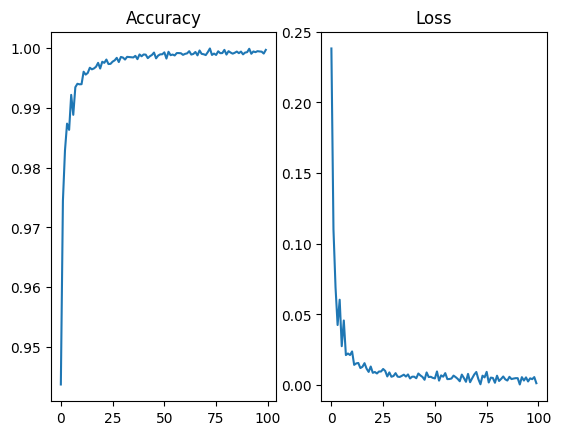

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax = ax.flatten()
ax[0].plot(range(len(history)), [h['accuracy'] for h in history])
ax[0].set_title('Accuracy')
ax[1].plot(range(len(history)), [h['loss'] for h in history])
ax[1].set_title('Loss')



100%|██████████| 313/313 [00:36<00:00,  8.57it/s]


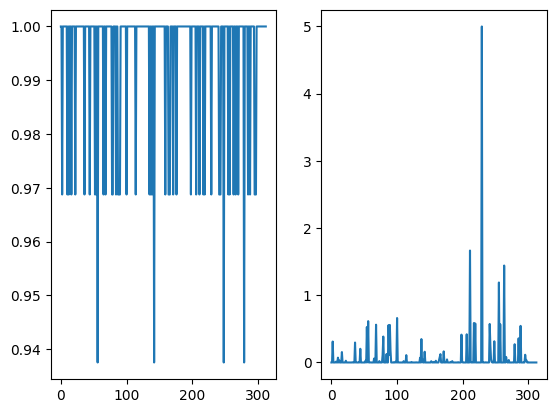

In [12]:
# Evaluate
history_test = []
total_steps = test_ds.cardinality().numpy()

for batch in tqdm(test_ds.as_numpy_iterator(), total=total_steps):
    # print(batch['image'].shape, batch['label'])
    _, logs = train_step(state, batch)
    logs = jax.tree_map(np.asarray, logs)
    history_test.append(logs)
    
fig, ax = plt.subplots(1, 2)
ax = ax.flatten()
ax[0].plot(range(len(history_test)), [h['accuracy'] for h in history_test])
ax[1].plot(range(len(history_test)), [h['loss'] for h in history_test])